# Transformer and Bert

2018년 당시에 [뉴옥 타임지]에서 `Oren Etzioni, chief executive of the Allen Institute for Artificial Intelligence`가 말하길,  
기계가 아직 인간의 보통 감각을 표현할 수는 없지만, Bert는 `폭발적인 발전`의 순간이라고 했습니다.
이 Bert 모델에 기초가 된 [Transformer]는 어텐션 매커니즘을 사용하여 Encoder-Decoder로 구성되는 구조를 보려고 합니다.

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/1_1_bert_transformer.png?raw=true" itemprop="image" width="40%">

또한 Bert구현의 바탕이 됬다고 직접 논문에서 언급한 [The Annotated Transformer]도 봅니다

[뉴옥 타임지]: https://www.nytimes.com/2018/11/18/technology/artificial-intelligence-language.html 
[Transformer]: https://arxiv.org/abs/1706.03762
[The Annotated Transformer]: https://nlp.seas.harvard.edu/2018/04/03/attention.html


### Attension Mechanism

어텐션은 특정 시퀀스를 출력하기 위해 입력 시퀀스의 어떠한 부분을 강조해야 될는지 학습을 할 수 있는 매커니즘이다.

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/4_1_transformer.png?raw=true" itemprop="image" width="60%">

어탠션 메커니즘은 간단히 말해서 특정 단어를 강조하는 것이다. 입력 시퀀스 중에서 특정 단어와 다른 단어가 시퀀스에서 출현시 강조되는 것이며, 그러한 강조 정보가 입력 시퀀스에 적용되어서 디코더에 입력되고, 매 디코더 시퀀스마다 이러한 계산이 진행되며 수많은 문장이 학습되면서 인코더 디코더에 입력되는 단어들의 상호간의 컨텍스트가 학습이 되는 구조이다.


<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/4_2_transformer.png?raw=true" itemprop="image" width="60%">

$$score(s_t, h_i )= s_t^T h_i 
\\e^t=[s_t^T h_1,…,s_t^T h_N]
\\a^t=softmax(e^t)
\\c_t = \sum_{i=1}^{N}a_i^t  h_i$$

원 논문에서는 t를 현재시점이라고 할 때, 인코더 출력벡터(s)와 은닉 상태 벡터(h)를 내적한 후에 소프트맥스(softmax)를 한다면 이를 어텐션 분포(attention distribution), 각각의 값을 어텐션 가중치(attention weight)라고 합니다. 이 가중치를 모두 더한다면 최종 출력 어텐션 값(attention value)이자 `문맥 벡터(context vector)`라고 정의한다. 그 후 실제 예측을 위해 어텐션 벡터와 인코더 출력벡터를 결합(concatenate)시켜 예측한다.


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

## Transformer 

트랜스포머는 전반적인 시퀀스 전달 모델은 인코더와 디코더를 포함하는 복잡한 순환(recurrent) 또는 합성곱(convolution)을 기반으로 한다. 최고의 성능의 모델들은 또한 어텐션([attention]) 을 통해 인코더와 디코더를 연결하는데, 새로운 단순한 네트워크 아키텍처인 트랜스포머를 오로지 `어텐션 메커니즘`에 기초하고, recurrent와 convolution를 사용하지 않는다. 논문에서는 2가지 번역 작업 실험에서 모델은 병렬적이고 동시에 품질이 우수하다는 것을 보여줬다.

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/1_transformer.png?raw=true" itemprop="image" width="60%">


[Attention]: https://arxiv.org/abs/1409.0473


### Positional Encoding

해당 모델에서는 순환(recurrence)이나  합성곱(convolution)을 전혀 사용하지 않았기 때문에, 반드시 위치 정보를 넣어줘야 한다.  따라서 positional encoding을 사용해서 입력 임베딩에 위치 정보를 넣어준다. 각 위치에 대해서 임베딩과 동일한 차원을 가지도록 인코딩을  해준 뒤 그 값을 임베딩값과 더해서 사용한다.

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/8_transformer.png?raw=true" itemprop="image" width="60%">

positional encoding에는 여러 방법이 있지만 여기서는 입력 문장길이에 대한 제약사항을 줄이리 위해 sin, cos 함수를 사용해서 정형파로 구현해서 사용했다.
각 위치 pos와 dimension i에 대한 positional encoding값은 다음과 같이 구한다.

$${PE}_{(pos,2i)}=sin⁡(pos/10000^{2i/d_{model}})
\\{PE}_{(pos,2i+1)}=cos⁡(pos/10000^{2i/{d}_{model} })$$

In [4]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)


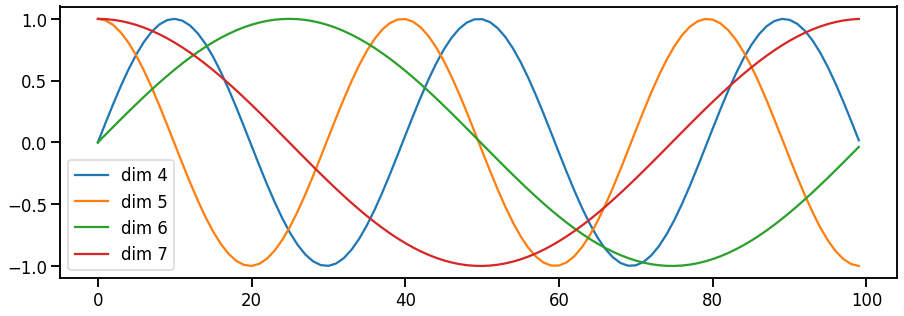

In [5]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

### Positional Encoding Bert
이에 반해 bert에서는 입력 token embedding과 Position Embeddings, Segment Embeddings, 추가해 각각의 임베딩, 즉 3개의 임베딩을 합산하여 입력으로 사용한다. 여기서 Segment는 Bert의 특성상 2개의 문장을 사용하는데 그 문장을 구분하는 벡터이다.

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/bert_Embedding.png?raw=true" itemprop="image" width="70%">



## Encoder & Decoder

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/5_1_transformer.png?raw=true" itemprop="image" width="50%">

출력은 모두 512차원

### Encoder

인코더는 동일한 계층(layer)가 N개 반복되는 형태인데, 원 논문에서는 6번 반복했다. Encoder는 계층은 두개의  하위 계층(sub-layer)로 구성된다. 첫 하위 계층은 멀티헤드(multi-head) 자가 어텐션 메커니즘(self-attention mechanism)이고 두번째는 간단하게 점별수렴(point-wise)하는 완전연결층(fc-layer)이. 그리고 모델 전체적으로 각 하위 계층에 RC([residual connection])가 전달되고, 이는 역전파가 계산되어 경사 하강이 될 때 원본 값을  더한후에 오차(Loss)가 계산된다. 그 후 계층  값을 레이어 정규화([Layer Normalization])한다. 즉 각 하위 계층은 결과에 대해 잔차  값을 더하고 그 값을 레이어 정규화 한 값이 출력으로 나오게 된다.

### Decoder

디코더도 인코더와 마찬가지로 동일한 계층이 N개 반복되는 형태이고 6번 반복한다. 그러나 반복되는 계층은 인코더와는 다르게 3개의 하위 계층으로 구성되어 있는데, 2개는 기존의 인코더의 하위 계층과 동일하고 나머지 하나는 인코더의 출력에 대해 멀티헤드 어텐션을  계산하는 하위 계층이 추가됬고 RC와 정규화가 이루어진다. 그리고 자가 어텐션은 인코더와는 약간 다르게 마스킹(masking)을 추가했는데, 자가 어텐션을 할 때 현재 위치보다 뒤에 있는 단어는 변하지 못하도록 마스킹을 추가해줬다. 다른위치의 단어는 auto-regressive한 특성을 이용해 알고 있는 정보로만 계산한다.

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/5_2_transformer.png?raw=true" itemprop="image" width="50%">

[Residual Connection]: https://arxiv.org/abs/1603.05027
[Layer Normalization]: https://arxiv.org/abs/1607.06450  


In [6]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)    


### RC([Residual Connection])

각 인코더와 디코더는 [residual connection]

[residual connection]을 수식으로 나타낸다면 
$y_l=h(x_l)+F(x_l,W_l )$  
여기서 $f(y_l)$는 ${x}_{l+1}$의 항등함수고 $h(x_l )$는 $x_l$ 로 맵핑된다.

이 때,  $x_{(l+1)}$  ≡  $y_l$ 라고한다면,
$x_{(l+1)}=x_l+F(x_l,W_l )$ 이고  
재귀적으로 $(x_{(l+2)}=x_{(l+1)}+F(x_{(l+1)},W_{(l+1)}) =x_l+ F(x_l, W_l)+F(x_{(l+1)},W_{(l+1)}), etc.).$

$$x_L=x_l+\sum\limits^{L-1}_{i=1}F(x_i,W_i)$$
이 식을 미분하면 $\frac{∂ε}{∂x_l}=\frac{∂ε}{∂x_L} \frac{∂x_L}{∂x_l}  = \frac{∂ε}{∂x_L}  (1+\frac{∂}{∂x_l} \sum\limits^{L-1}_{i=1}  F(x_i,W_i))$

여기서 $\frac{∂ε}{∂x_L}$ 는 모든 레이어에 적용 되고,  F가 0이 되는 경우는 희박하기 때문에 가중치 $ε$ 가 매우 작더라도 `Vanishing Gradient`되는 경우는 거의 없다.

[Residual Connection]: https://arxiv.org/abs/1603.05027

In [7]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

### Scaled Dot-Product Attention

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/6_1_transformer.png?raw=true" itemprop="image" width="50%">

해당 어텐션의 입력은 3가지이다. D개  차원을 가지는 queries(Q)와 keys(K), values(V)로 구성된다. 먼저 Q는 주로 디코더의 은닉 상태 벡터, K는 인코더의 은닉 상태 벡터, V는 K에 정렬 모델(alignment model)로 계산된 어텐션 가중치이다.  
- Query: query는 다른 모든 단어에 대해 점수를 매기기 위해 사용되는 현재 단어의 표현이다(키 사용). 우리는 현재 진행중인 프로세스 토큰의 질의에만 신경을 쓴다.  
- Key: key 벡터는 세그먼트에 있는 모든 단어에 대한 라벨과 같다. 관련된 단어들을 찾을 때 매칭된다.  
- Value: value 벡터는 실제 단어 표현이다. 각 단어가 얼마나 관련이 있는지 계산되었을 떄, value를 이용해서 현재 단어의 가중치를 계산한다.

비유를 하자면, query는 연구하고 있는 주제를 가지고 있는 메모라고 한다면, key는 캐비닛 안에 있는 폴더의 태그라고 할 때, 
태그를 스티커 메모와 일치시키면, 폴더의 내용은 value. 이 떄, 하나의 값만 찾는 것이 아니라 폴더의 혼합된 값의 조합을 찾은 후 query 벡터와 각 키 vector를 곱한 값이 각 폴더의 점수이다.  
즉, 하나의 query에 대해 모든 key들과 내적을 한 뒤 각 값을 k의 차원수인 $\sqrt{d}_{k}$로 나눠주면서 스케일링한다. 그리고 소프트맥스 함수를 씌운 후 마지막으로 값을 곱합다.
$\  Attension(Q, K, V)=softmax(\frac{(QK^T)}{√(d_k)})V$

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/6_3_transformer.png?raw=true" itemprop="image" width="50%">


### Multi-Head Attention

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/7_1_transformer.png?raw=true" itemprop="image" width="50%">

Query, key, value 들에 각각 다른 학습된 선형  투영(linear projection)을 h번 수행한다. 즉, 동일한 Q,K,V에 각각 다른 weight matrix W를 곱합니다. 그 후 각각 어텐션을 병합(concatenate)한다.

$$MultiHead(Q,K,V)=Concat(head_1,…,head_h)W^o
\\ where head_i=Attention(QW_i^Q,KW_i^K,VW_i^V)  $$

어텐션  레이어가  h개 씩으로 나눠짐에 따라 모델은 여러 개의 표현 공간(representation subspaces)들을 가지게 해주는데, Query, key, Value weight 행렬들은 학습이 된 후 각각의 입력벡터들에게 곱해져 벡터들을단어의 정보에 맞추어 투영시키게 된다.

<img src="./images/transformers/7_3_transformer.png" itemprop="image">

###  Position-wise Feed-Forward Networks

어텐션 하위 계층에서 fully connected feed-forward network로 진행하는 과정이고 두개의 선형 회귀으로 구성되어 있다.

$\ FFN(x)=max⁡(0,xW1+b1)W2+b2FFN(x)=max⁡(0,xW1+b1)W2+b2$

두 레이어 사이에 Trasformer는 ReLU 함수를 Bert는 erf off [GELU]를 사용한다.

<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/gelu_relu.png?raw=true" itemprop="image" width="50%">


[GELU]: https://arxiv.org/abs/1606.08415


In [8]:
def gelu(x):
    cdf = 0.5 * (1.0 + torch.erf(x / np.sqrt(2.0)))
    return x * cdf



## Why Self-Attention 

원 논문에서는 이 모델에서 순환나  합성곱을 사용하지 않고 자가 어탠션(self-attention)만을 사용한 이유에 대해서 알아보면, 3가지 이유로 자가 어탠션을 선택했다

1. 레이어당 전체 연산량이 줄어든다(시간복잡도).

2. 병렬화가 가능한 연산량이 늘어난다.

3. 거리가 먼 단어들의 종속성(long-range 또는 long-term dependency)때문

그리고 위의 3가지 외에 또 다른 이유는 어탠션을 사용하면 모델 자체의 동작을 해석하기 쉬워진다(interpretable). 어탠션 하나의 동작 뿐만 아니라 multi-head의 동작 또한 어떻게 동작하는지 이해하기 쉽다는 장점이 있다.


<img src="https://github.com/indexxlim/indexxlim.github.io/blob/main/diary.py/machine_learning/paper/images/transformers/9_transformer.png?raw=true" itemprop="image">

### reference 

•[Transformer]  
•[Bert]  
•[Attention]  
•[Residual Connection]  
•[Layer Normalization]  
•[Label Smoothing]

•[The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)  
•[The Illustrated GPT-2 (Visualizing Transformer Language Models)](http://jalammar.github.io/illustrated-gpt2/#part-2-illustrated-self-attention)
•[https://pozalabs.github.io/transformer/](https://pozalabs.github.io/transformer/)  
•[http://freesearch.pe.kr/archives/4876#easy-footnote-bottom-2-4876](http://freesearch.pe.kr/archives/4876)  
•[https://wikidocs.net/22893](https://wikidocs.net/22893)  
•http://docs.likejazz.com/bert/

[Transformer]: https://arxiv.org/abs/1706.03762
[Bert]: https://arxiv.org/abs/1810.04805  
[Attention]: https://arxiv.org/abs/1409.0473
[Residual Connection]: https://arxiv.org/abs/1603.05027
[Layer Normalization]: https://arxiv.org/abs/1607.06450  
[Label Smoothing]: https://arxiv.org/pdf/1512.00567.pdf
[뉴옥 타임지]: https://www.nytimes.com/2018/11/18/technology/artificial-intelligence-language.html 


# BERT extention

### Bidirectional
저자는 unidirectional은 token-level에서 단점이 된다고 한다. GPT 같은 unidirectional 한 모델, 즉 모든 토큰은 이전 토큰만 참고할 수 있는 auto-regressive 모델과는 달리 BERT의 경우 이전과 이후의 정보를 모두 활용한다. 계산량도 물론 2배.

### Masked Language Model
은 문장의 다음 단어를 예측하는 것이 아니라 문장내 랜덤한 단어를 마스킹하고 이를 예측하도록 하는 방식으로 Word2Vec의 CBOW 모델과 유사하다. 하지만 MLM은 Context 토큰을 Center 토큰이 되도록 학습하고 Weights를 벡터로 갖는 CBOW와 달리, 마스킹된 토큰을 맞추도록 학습한 결과를 직접 벡터로 갖기 때문에 보다 직관적인 방식으로 볼 수 있다. 마스킹은 전체 단어의 15% 정도만 진행하며, 그 중에서도 모든 토큰을 마스킹 하는게 아니라 80% 정도만 <MASK>로 처리하고 10%는 랜덤한 단어, 나머지 10%는 정상적인 단어를 그대로 둔다.

### Next Sentence Prediction(NSP)

Bert는 2문장을 입력으로 넣을 때, ```[cls] 문장 [sep] 문장``` 형식을 입력으로 사용한다. 원저자 no NSP라면 Accuracy가 0.5정도 떨어진다고 하는데, 반론을 펼치는 논문도 많으므로 넘어간다.

### Effect of Model Size

Bert Base의 모델은 L=12, H=768, A=12 110M parameter  
Large 모델은 L=24, H=1024, A,16      340M parameter

다른 bi-LSTM([context2vec]) 같은 경우 히든벡터의 차원수를 200에서 600까지 올리는것은 유의미했지만 1000까지 올리는 것은 도움이 되지 않았다.  
반면 transformer는 대용량 모델의 학습을 가능케 한다.


[context2vec]: https://www.aclweb.org/anthology/K16-1006.pdf